# Run the Force-directed Structure Generator
Use a simple algorithm and see how we do

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from hydronet.inversion.force import convert_directed_graph_to_xyz
from hydronet.inversion import evaluate_inversion
from hydronet.data import atoms_from_dict
from scipy.stats import kendalltau
from random import choices
from tqdm import tqdm
import pandas as pd
import json

## Perform the analysis on all structures.
Take the known geometry, make the graph, invert the graph and report how different the new geometry is

In [2]:
results = []
with open('../benchmark_clusters.json') as fp:
    lines = fp.readlines()
    for line in tqdm(lines):
        record = json.loads(line)
        result = evaluate_inversion(convert_directed_graph_to_xyz, atoms_from_dict(record))        
        record.update(result)
        results.append(record)

100%|██████████| 2270/2270 [55:46<00:00,  1.47s/it]  


In [3]:
results = pd.DataFrame(results)

## Assess the Results
I want to see how often we get the 'correct' graph or one that is energetically degenerate under different conditions

### Do we get isometric graphs?
See if we recover the initial graph

In [4]:
print(f'Overall isometric success rate: {results["is_isometric"].mean()*100:.1f}%')

Overall isometric success rate: 25.8%


See by system size

Text(0.5, 0, 'Cluster Size')

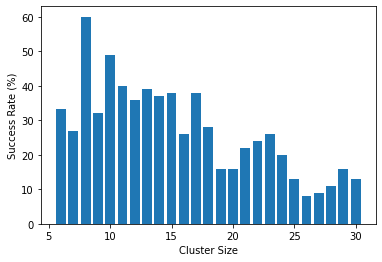

In [5]:
fig, ax = plt.subplots()

by_size = results.groupby('n_water')['is_isometric'].mean()
ax.bar(by_size.index, by_size * 100)

ax.set_ylabel('Success Rate (%)')
ax.set_xlabel('Cluster Size')

Success rate is not great. We achieve a rate of <30% for large clusters.

## How large are the energy differences? 
Are they large in absolute magnitude? Large enough to interfere with ranking

Text(0.5, 0, 'Cluster Size')

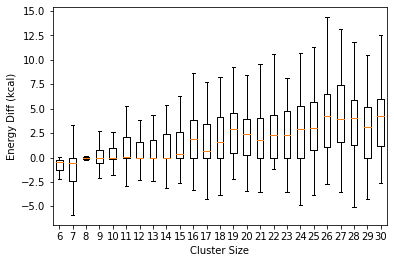

In [6]:
fig, ax = plt.subplots()

by_size = results.groupby('n_water')['energy_diff'].apply(list)
ax.boxplot(by_size.tolist(), positions=by_size.index, showfliers=False)

ax.set_ylabel('Energy Diff (kcal)')
ax.set_xlabel('Cluster Size')

Energy difference can be quite large and are easily in the ~0.1 kcal/water range.

Measure ranking performance with Kendal tau

In [7]:
results['new_energy'] = results['energy'] + results['energy_diff']

Text(0.5, 0, 'Cluster Size')

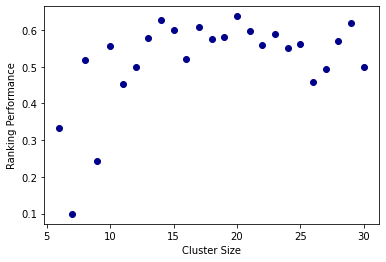

In [8]:
fig, ax = plt.subplots()

for size, group in results.groupby('n_water'):
    rank_val = kendalltau(group['energy'], group['new_energy'])
    ax.scatter([size], [rank_val.correlation], color='darkblue')

ax.set_ylabel('Ranking Performance')
ax.set_xlabel('Cluster Size')

The ranking performance is better than random, but not great. It seems that we expect 50% of pairs to be in the correct order.